In [122]:
# Writer : JESOON KANG, Dept. of Computer Science & Engineering in Chung-Ang University
# Last-Modified Date : April 23,2020

In [123]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import time
import datetime
from random import *

In [124]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2060 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


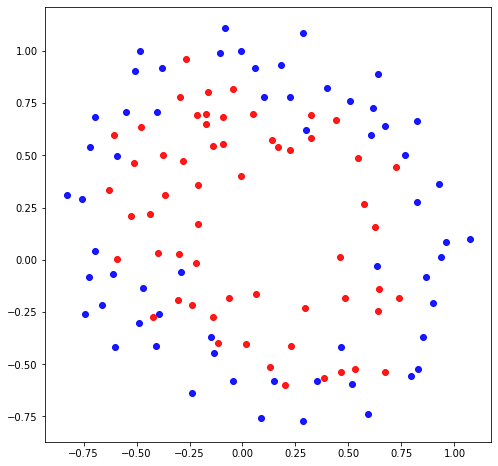

In [125]:
# Plot the training data
import numpy as np
import matplotlib.pyplot as plt

data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')

x       = data[:, 0]
y       = data[:, 1]
label   = data[:, 2]

x_label0    = x[label == 0]
y_label0    = y[label == 0]

x_label1    = x[label == 1]
y_label1    = y[label == 1]

plt.figure(figsize=(8, 8))
plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
plt.show()

In [126]:
x = torch.DoubleTensor(x).to('cuda')
y = torch.DoubleTensor(y).to('cuda')
label = torch.DoubleTensor(label).to('cuda')
x = x.unsqueeze(1)
y = y.unsqueeze(1)
label = label.unsqueeze(1)

In [127]:
test = torch.DoubleTensor([1e-7])
print("{:f}".format(test.item()))

0.000000


In [128]:
def show_graph (thetas) :
    thetas_len = len(thetas)
    
    mesh_x = torch.linspace(-2,2,256,dtype=torch.double).to('cuda')
    mesh_y = torch.linspace(-2,2,256,dtype=torch.double).to('cuda')
    XX, YY = torch.meshgrid(mesh_x,mesh_y)
    if thetas_len == 10 :
        ZZ = get_function_3(XX,YY)
    elif thetas_len == 16 :
        ZZ = get_function_4(XX,YY)

    ZZ = torch.reshape(ZZ,(thetas_len,65536))
    ZZ = torch.matmul(thetas.T,ZZ)
    ZZ = torch.reshape(ZZ,(256,256))
    yh = 1 / (1 + torch.exp(-ZZ))
    plt.figure(figsize=(6, 6))
    plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
    plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
    plt.contour(XX.cpu(), YY.cpu(), yh.cpu(), levels= [0.5])
    plt.show()
    
def get_running_time(start_time) :
    running_time = datetime.datetime.now() - start_time
    running_time = running_time.seconds
    hours, remainder = divmod(running_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours, minutes, seconds

In [139]:
def get_function_4(x,y) :
    constant = torch.ones(x.shape,dtype=torch.float64).to('cuda')
    ret = torch.stack((constant,x,y,\
                       x*y,x**2,y**2,\
                       x**2*y, x*y**2,x**3,y**3,\
                       x**3*y, x*y**3,\
                       x**3*y**2,x**2*y**3,\
                       x**3*y**3,x**5*y**5\
                      ))
    ret = ret.squeeze(-1)
    return ret


In [130]:

# Setting Step-size. (Learning-rate)
lr = 1e-3
lr = torch.DoubleTensor([lr]).to('cuda')

# Setting converge value
loss_conv = 5e-9 # loss converge standard

# Lists for logging
loss_log = []
epoch_log = []
acc_log = []
conv_count = 0 # Variable To count converge
epoch = 0 # Inital epoch value

thetas = torch.ones((16,1),dtype=torch.float64).to('cuda') 
fx = get_function_4(x,y)

start_time = datetime.datetime.now()
while (True) :
    epoch +=1
    epoch_log.append(epoch)
    z = torch.matmul(thetas.T,fx)
    z = z.T
    activ_values = 1 / (1+torch.exp(-z))
    m = len(activ_values)
    
    # Get Loss 
    loss = (1/m) * torch.sum( \
                             -label*torch.log(activ_values) - (1-label)*torch.log(1 - activ_values))
    # Logging
    loss_log.append(loss)
    
    # Updating Parameters - Gradient Descent
    thetas[0] -= lr * (1/m) * torch.sum(activ_values-label)
    thetas[1] -= lr * (1/m) * torch.sum( (activ_values-label)* x)
    thetas[2] -= lr * (1/m) * torch.sum( (activ_values-label)* y)
    thetas[3] -= lr * (1/m) * torch.sum( (activ_values-label)* x*y)
    thetas[4] -= lr * (1/m) * torch.sum( (activ_values-label)* x**2)
    thetas[5] -= lr * (1/m) * torch.sum( (activ_values-label)* y**2)
    thetas[6] -= lr * (1/m) * torch.sum( (activ_values-label)* x**2*y)
    thetas[7] -= lr * (1/m) * torch.sum( (activ_values-label)* x*y**2)
    thetas[8] -= lr * (1/m) * torch.sum( (activ_values-label)* x**3)
    thetas[9] -= lr * (1/m) * torch.sum( (activ_values-label)* y**3)
    thetas[10] -= lr * (1/m) * torch.sum( (activ_values-label)* x**3*y)
    thetas[11] -= lr * (1/m) * torch.sum( (activ_values-label)* x*y**3)
    thetas[12] -= lr * (1/m) * torch.sum( (activ_values-label)* x**3*y**2)
    thetas[13] -= lr * (1/m) * torch.sum( (activ_values-label)* x**2*y**3)
    thetas[14] -= lr * (1/m) * torch.sum( (activ_values-label)* x**3*y**3)
    thetas[15] -= lr * (1/m) * torch.sum( (activ_values-label)* y**5*y**5)
    

    ## Does Train Loss Converged?
    if len(loss_log) > 2 :
        if abs(loss_log[-1] - loss_log[-2]) < loss_conv :
            conv_count += 1
        else :
            conv_count = 0
    
    # For monitor
    if epoch %100000 == 0 :
        acc = 0
        for i in range(0,len(activ_values)) :
            if activ_values[i] >= 0.5 :
                if label[i] == 1 :
                    acc += 1
            else :
                if label[i] == 0 :
                    acc += 1
        acc = acc / len(activ_values)
        acc_log.append(acc)
        
        running_time = get_running_time(start_time)
        
        print("lr : {}, epoch {},loss {:.10f}, acc {:.3f}, time : {:02d}:{:02d}:{:02d}".\
              format(lr.item(), epoch,loss_log[-1],acc_log[-1],running_time[0],running_time[1],running_time[2]) )
        #show_graph(thetas)
    ## Escape if Training loss is converged
    if conv_count > 4 :

        print("Loss is converged")
        print("#"*30)
        running_time = get_running_time(start_time)

        print("lr : {}, epoch {},loss {:.10f}, acc {:.3f}, time : {:02d}:{:02d}:{:02d}".\
              format(lr.item(), epoch,loss_log[-1],acc_log[-1],running_time[0],running_time[1],running_time[2]) )               
        print("#"*30)
        
        break

KeyboardInterrupt: 

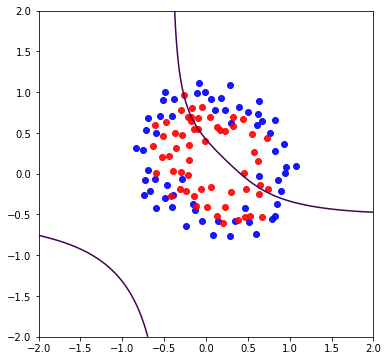

In [138]:
from IPython.display import display, Math, Latex

# Result Section

# 1. Plot the training data

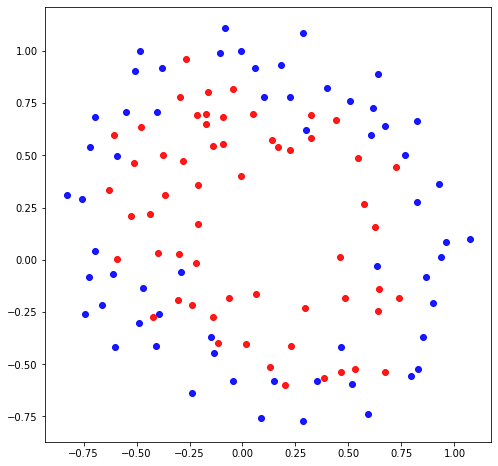

In [133]:
plt.figure(figsize=(8, 8))
plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
plt.show()

# 2. Write down the high dimensional function $g(x, y); \theta)$

${\Large
  g(x, y ; \theta) =
  1\times 
  f_{0}(x, y)
  + x f_{1}(x, y)
  + y f_{2}(x, y)
  \\ \Large
  + xy f_{3}(x, y)
  + x^{2} f_{4}(x, y)
  + y^{2} f_{5}(x, y)
  + x^{2}y f_{6}(x, y)
  \\ \Large
  + xy^{2} f_{7}(x, y)
  + x^{3} f_{8}(x, y)
  + y^{3} f_{9}(x, y)
  + x^{3}y f_{10}(x, y)
  \\ \Large
  + xy^{3} f_{11}(x, y)
  + x^{3}y^{2} f_{12}(x, y)
  + x^{2}y^{3} f_{13}(x, y)
  + x^{3}y^{3} f_{14}(x, y)
  + x^{5}y^{5} f_{15}(x, y)
}$


# 3. Plot the training error

Converged Training loss : 0.83910


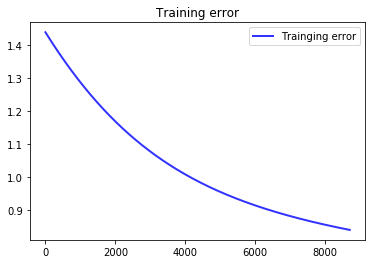

In [136]:
plt.title("Training error")
plot, = plt.plot(epoch_log,loss_log, color='blue',linewidth=2,alpha=0.8)
plt.legend([plot],["Trainging error"])
print("Converged Training loss : {:.5f}".format(loss_log[-1].item()))

# 5. Write down the final training accuracy

## Final training accuracy : 85.6%

# 6. Plot the optimal classifier superimposed on the training data

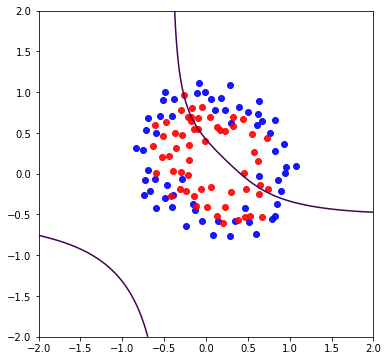

In [137]:
thetas_4 = thetas
show_graph(thetas_4)